In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import *

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 150)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)
sns.set()

df = pd.read_csv('data_part_2.csv')

print(df.shape)
df.head()

(1009, 18)


,user_id,region,device,channel,session_start,session_end,sessiondurationsec,session_date,month,day,hour_of_day,order_dt,revenue,payment_type,promo_code,final_price,time_of_day,sold
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0,9999.0,night,1
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN,NaN,morning,0
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN,NaN,night,0
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN,NaN,evening,0
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN,NaN,day,0


In [5]:
df['time_of_day'].unique()

array(['night', 'morning', 'evening', 'day'], dtype=object)

# Set Proper Data Types

In [6]:
dtype_mapping = {
    'user_id': 'int64', 
    'region': 'object', 
    'device': 'object', 
    'channel': 'object', 
    'session_start': 'datetime64[ns]', 
    'session_end': 'datetime64[ns]', 
    'sessiondurationsec': 'float64', 
    'session_date': 'datetime64[ns]', 
    'month': 'int64', 
    'day': 'int64', 
    'hour_of_day': 'int64', 
    'order_dt': 'datetime64[ns]', 
    'revenue': 'float64', 
    'payment_type': 'object', 
    'promo_code': 'float64'
}

df = df.astype(dtype_mapping)

# Custom Functions 1

In [7]:
def calculate_monthly_metric(
    df, 
    group_col=None, 
    metric_column='sold', 
    aggregation_method="sum", 
    revenue_type=None
):
    """
    Calculate monthly metrics with flexible grouping, column selection, and revenue analysis.
    
    Args:
        df (pd.DataFrame): Input dataframe
        group_col (str, optional): Column to group by
        metric_column (str): Column to aggregate ('sold' or 'revenue')
        aggregation_method (str): 'sum', 'count', or revenue-specific methods
        revenue_type (str, optional): For revenue metrics - 'total', 'aov', or 'arpu'
    
    Returns:
        pd.DataFrame: Aggregated monthly metrics
    """
    # Validate inputs
    valid_metric_columns = ['sold', 'revenue']
    if metric_column not in valid_metric_columns:
        raise ValueError(f"metric_column must be one of {valid_metric_columns}")
    
    # Prepare grouping columns
    group_columns = ['month'] if group_col is None else [group_col, 'month']
    
    # Handle revenue-specific calculations
    if metric_column == 'revenue':
        if aggregation_method == 'sum':
            # Total revenue
            metric = df.groupby(group_columns, observed=False)['revenue'].sum()
        elif aggregation_method == 'aov':
            # Average Order Value
            # First, calculate total revenue and count of orders per group
            revenue_sum = df[df['sold'] == 1].groupby(group_columns, observed=False)['revenue'].sum()
            order_count = df[df['sold'] == 1].groupby(group_columns, observed=False)['sold'].count()
            metric = revenue_sum / order_count
        elif aggregation_method == 'arpu':
            # Average Revenue Per User
            revenue_sum = df.groupby(group_columns, observed=False)['revenue'].sum()
            user_count = df.groupby(group_columns, observed=False)['user_id'].nunique()
            metric = revenue_sum / user_count
        else:
            raise ValueError("For revenue, use 'sum', 'aov', or 'arpu'")
    else:
        # Original sold column logic
        if aggregation_method == "sum":
            metric = df.groupby(group_columns, observed=False)['sold'].sum()
        elif aggregation_method == "count":
            metric = df.groupby(group_columns, observed=False).size()
        else:
            raise ValueError("For sold, use 'sum' or 'count'")
    
    # Reset index and rename columns
    metric = metric.reset_index(name='metric')
    
    # Convert month to month name
    metric['month'] = pd.to_datetime(metric['month'], format='%m').dt.strftime('%B')
    
    return metric

def plot_monthly_metric(
    metric, 
    group_col=None, 
    use_markers=True, 
    metric_column='sold', 
    aggregation_method="count"
):
    """
    Visualize monthly metrics with flexible plotting options.
    
    Args:
        metric (pd.DataFrame): Aggregated metric dataframe
        group_col (str, optional): Grouping column
        use_markers (bool): Whether to show markers
        metric_column (str): 'sold' or 'revenue'
        aggregation_method (str): Aggregation method
    """
    plt.figure(figsize=(12, 6))
    
    # Set title based on metric and aggregation method
    title_mapping = {
        ('sold', 'sum'): "Number of Purchases",
        ('sold', 'count'): "Overall Activity",
        ('revenue', 'sum'): "Total Revenue",
        ('revenue', 'aov'): "Average Order Value",
        ('revenue', 'arpu'): "Average Revenue Per User"
    }
    title_metric = title_mapping.get((metric_column, aggregation_method), "Metric")
    
    # Plot logic
    if group_col:
        groups = metric[group_col].unique()
        colors = sns.color_palette("husl", len(groups))
        
        for group, color in zip(groups, colors):
            group_data = metric[metric[group_col] == group]
            plt.plot(
                group_data['month'], 
                group_data['metric'], 
                label=group, 
                linewidth=2.5,
                marker='o' if use_markers else None, 
                color=color
            )
        plt.legend(title=group_col)
    else:
        plt.plot(
            metric['month'],
            metric['metric'], 
            linewidth=2.5,
            marker='o' if use_markers else None,
            color=sns.color_palette("husl", 1)[0]
        )
    
    plt.title(f"{title_metric} per Month" + (f" by {group_col}" if group_col else ""))
    plt.xlabel("Month")
    plt.ylabel(title_metric)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# 1. How many visitors came to our website each month?

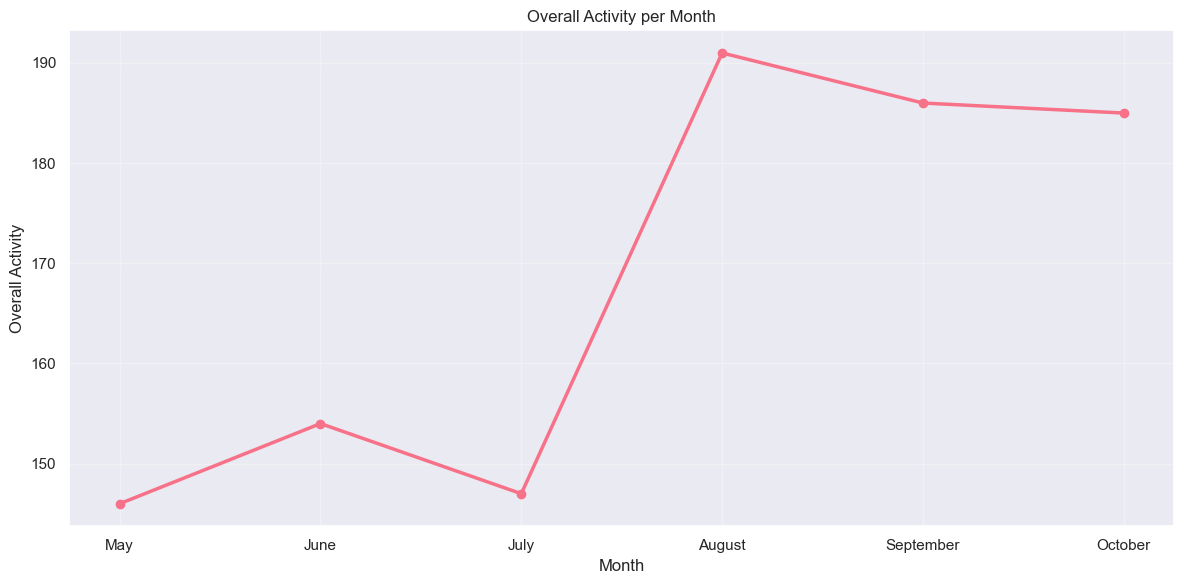

In [8]:
monthly_activity_general = calculate_monthly_metric(df, aggregation_method='count')

plot_monthly_metric(monthly_activity_general, aggregation_method='count')

# 2. How many purchases were made and how much revenue did we generate each month?

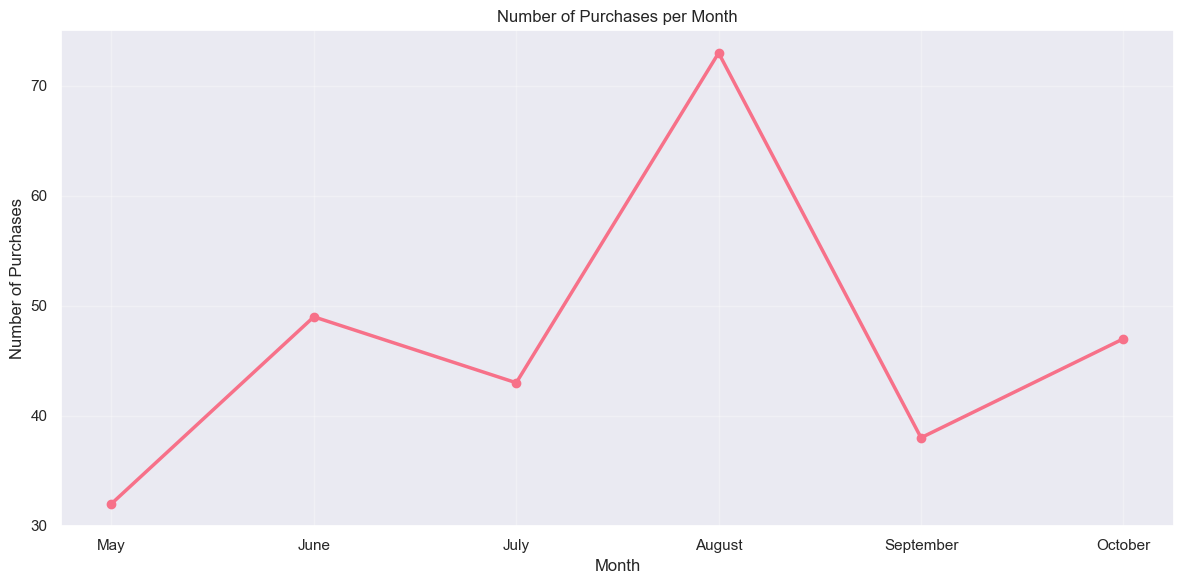

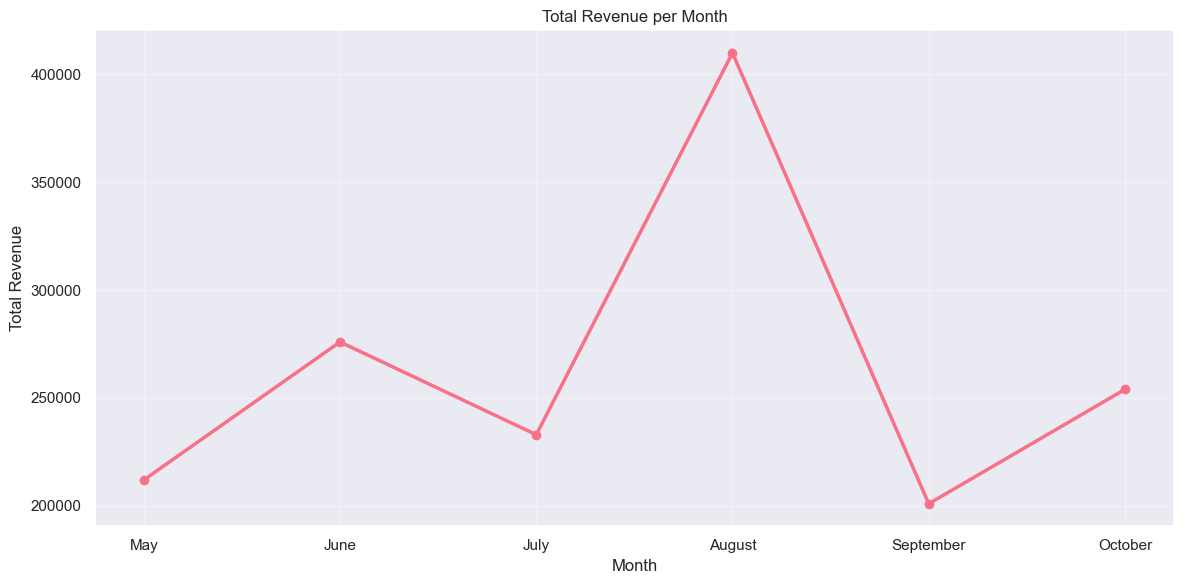

In [9]:
# Total purchases per month
total_purchases = calculate_monthly_metric(df, aggregation_method="sum")
plot_monthly_metric(total_purchases, aggregation_method="sum")

# Total revenue per month
total_revenue = calculate_monthly_metric(df, metric_column='revenue', aggregation_method="sum")
plot_monthly_metric(total_revenue, metric_column='revenue', aggregation_method="sum")

# 3. Which regions are driving the most sales and generating the highest revenue?

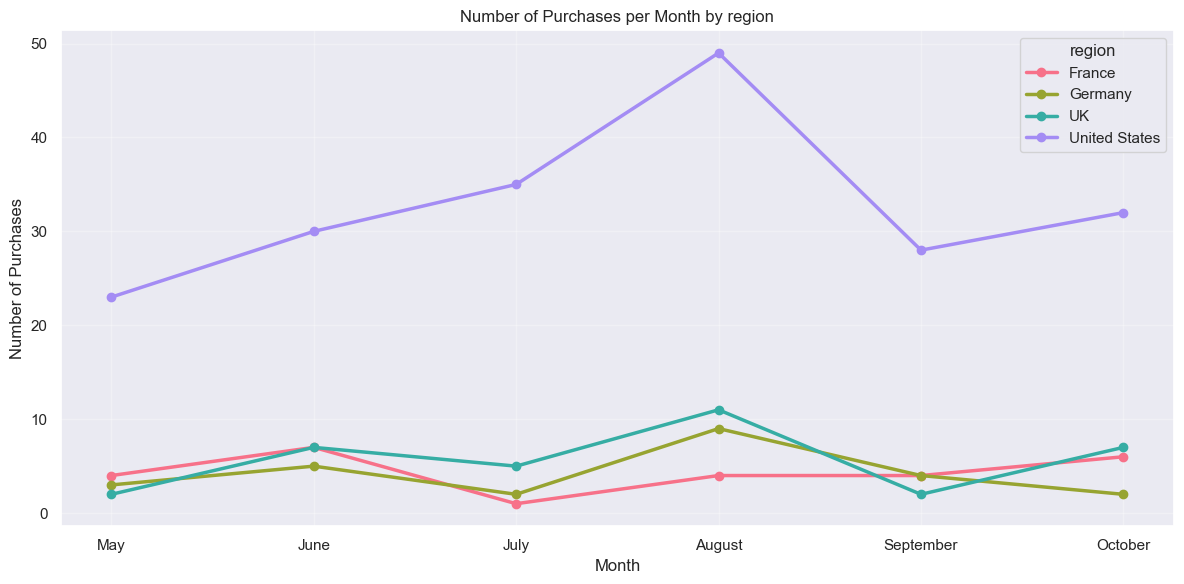

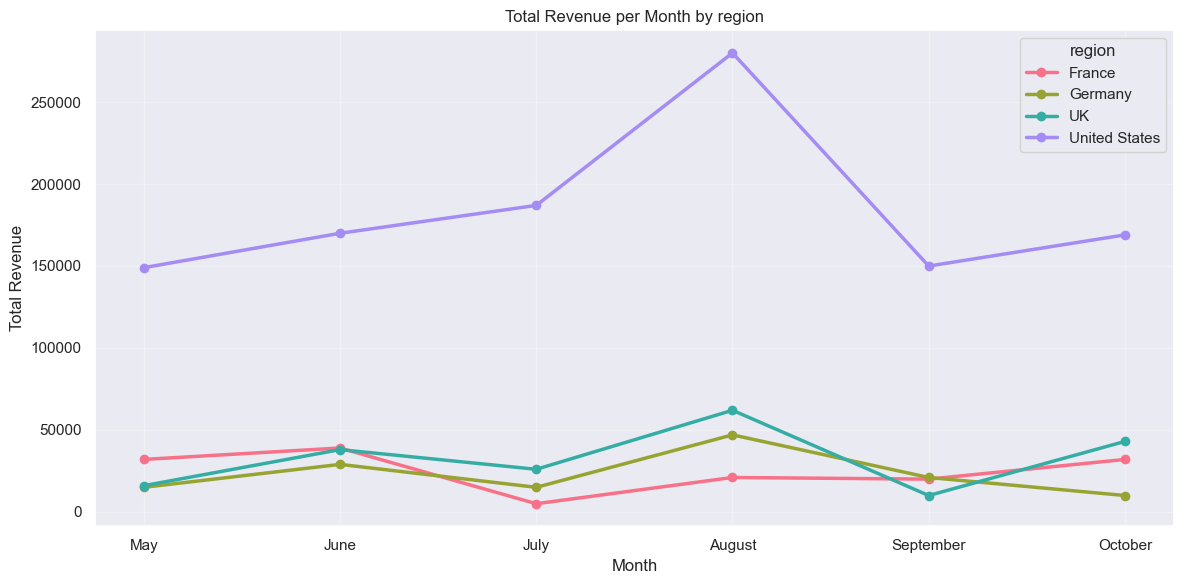

In [10]:
# Purchases by region
purchases_by_region = calculate_monthly_metric(df, group_col='region', aggregation_method="sum")
plot_monthly_metric(purchases_by_region, group_col='region', aggregation_method="sum")

# Revenue by region
revenue_by_region = calculate_monthly_metric(df, group_col='region', metric_column='revenue', aggregation_method="sum")
plot_monthly_metric(revenue_by_region, group_col='region', metric_column='revenue', aggregation_method="sum")

# 4. Which devices are customers using to make purchases?

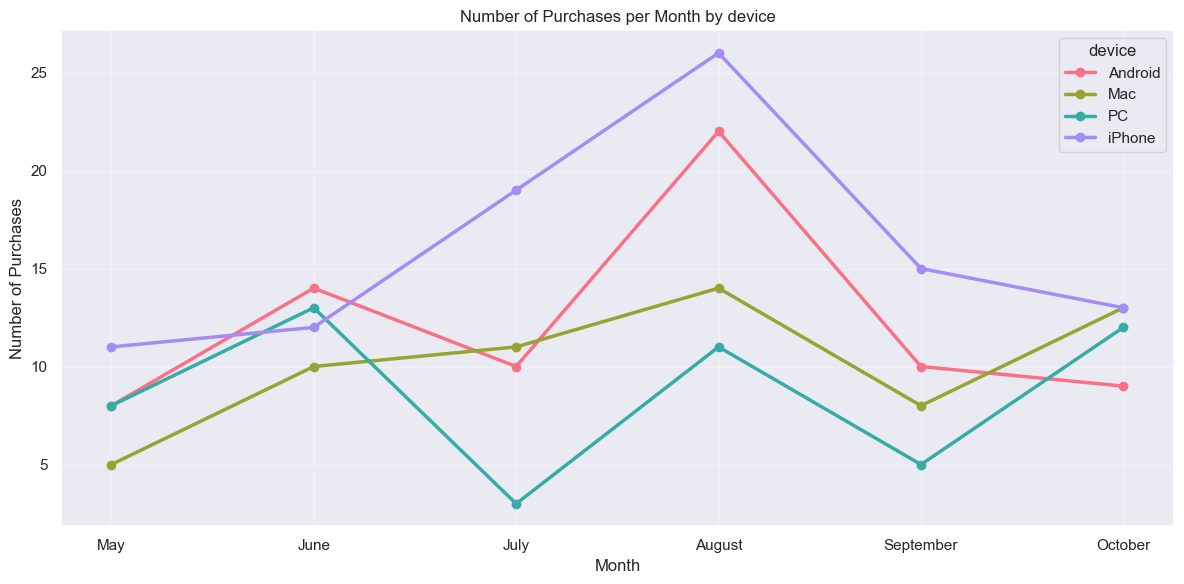

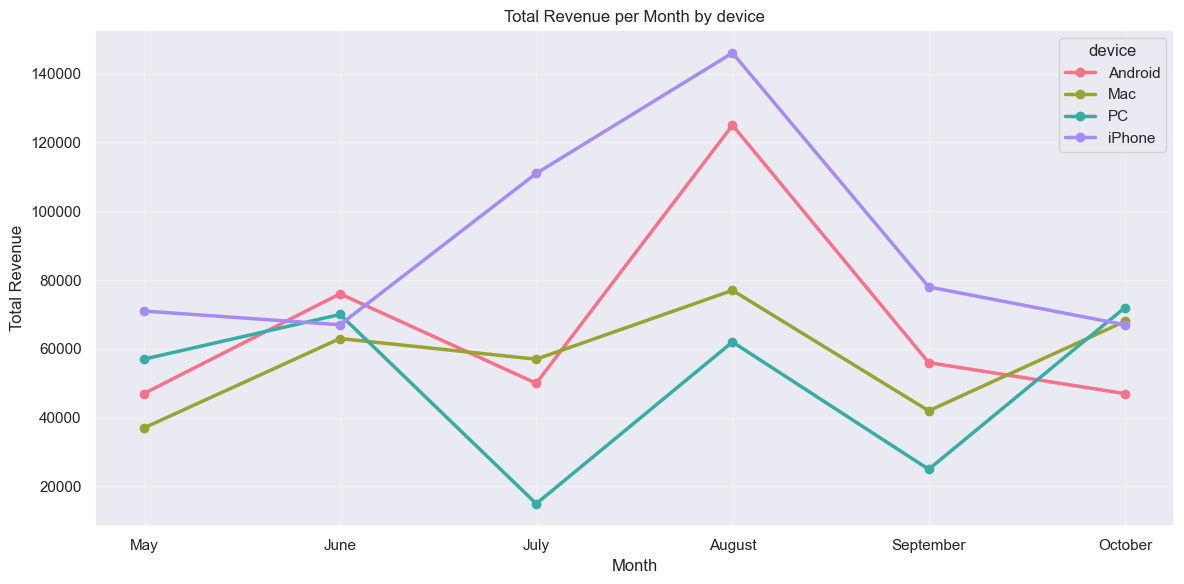

In [11]:
# Purchases by device
purchases_by_device = calculate_monthly_metric(df, group_col='device', aggregation_method="sum")
plot_monthly_metric(purchases_by_device, group_col='device', aggregation_method="sum")

# Revenue by device
revenue_by_device = calculate_monthly_metric(df, group_col='device', metric_column='revenue', aggregation_method="sum")
plot_monthly_metric(revenue_by_device, group_col='device', metric_column='revenue', aggregation_method="sum")

# 5. Which marketing channels are most effective in driving sales?

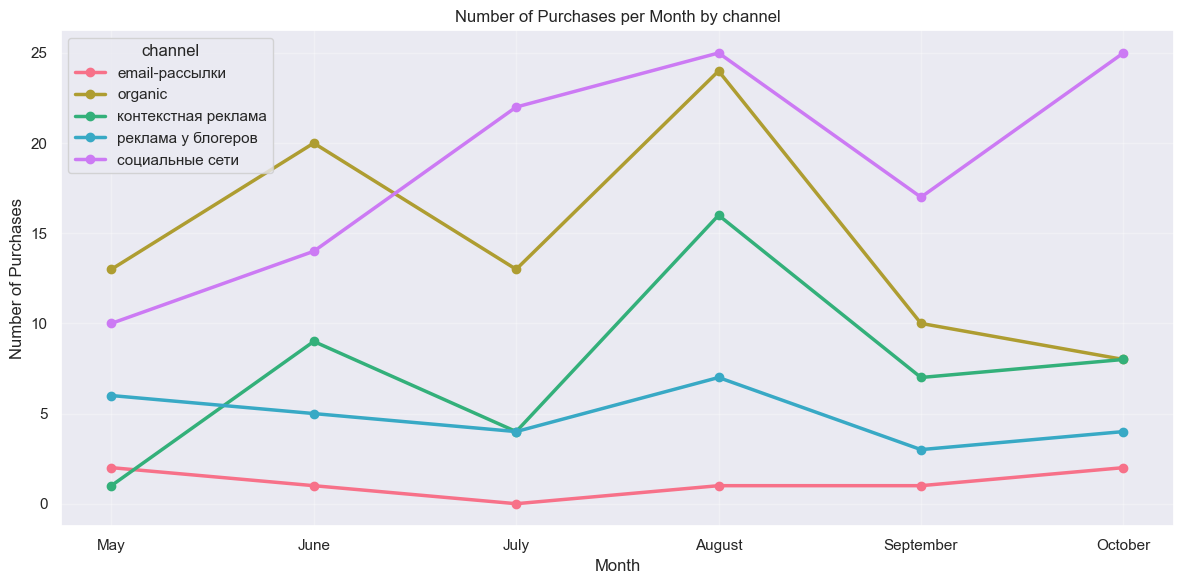

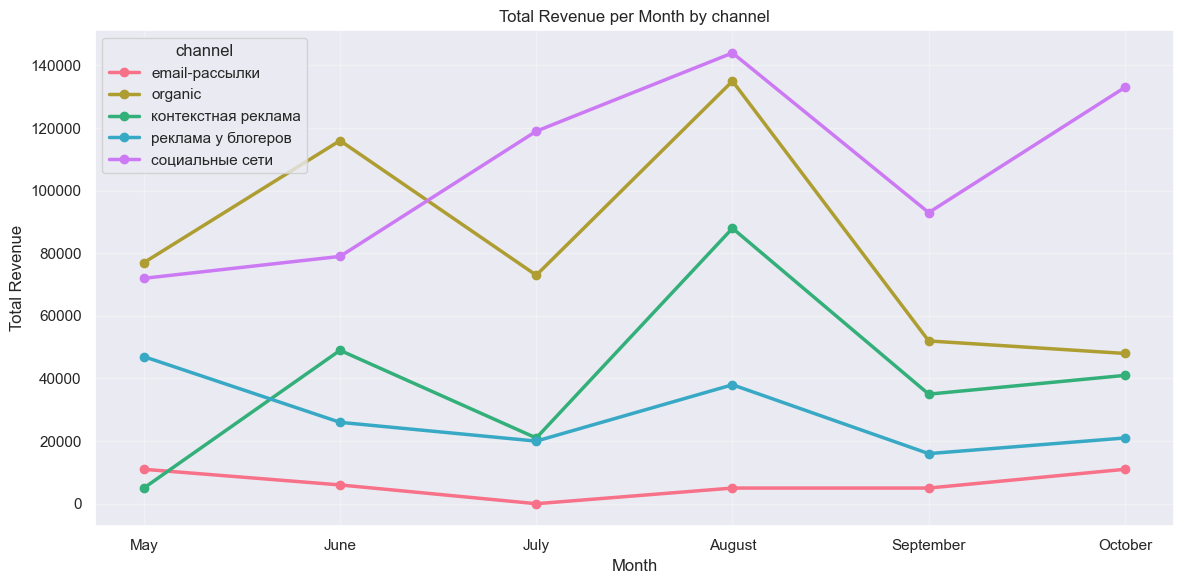

In [12]:
# Purchases by channel
purchases_by_channel = calculate_monthly_metric(df, group_col='channel', aggregation_method="sum")
plot_monthly_metric(purchases_by_channel, group_col='channel', aggregation_method="sum")

# Revenue by channel
revenue_by_channel = calculate_monthly_metric(df, group_col='channel', metric_column='revenue', aggregation_method="sum")
plot_monthly_metric(revenue_by_channel, group_col='channel', metric_column='revenue', aggregation_method="sum")

# 6. What is the average value of each order and each user?

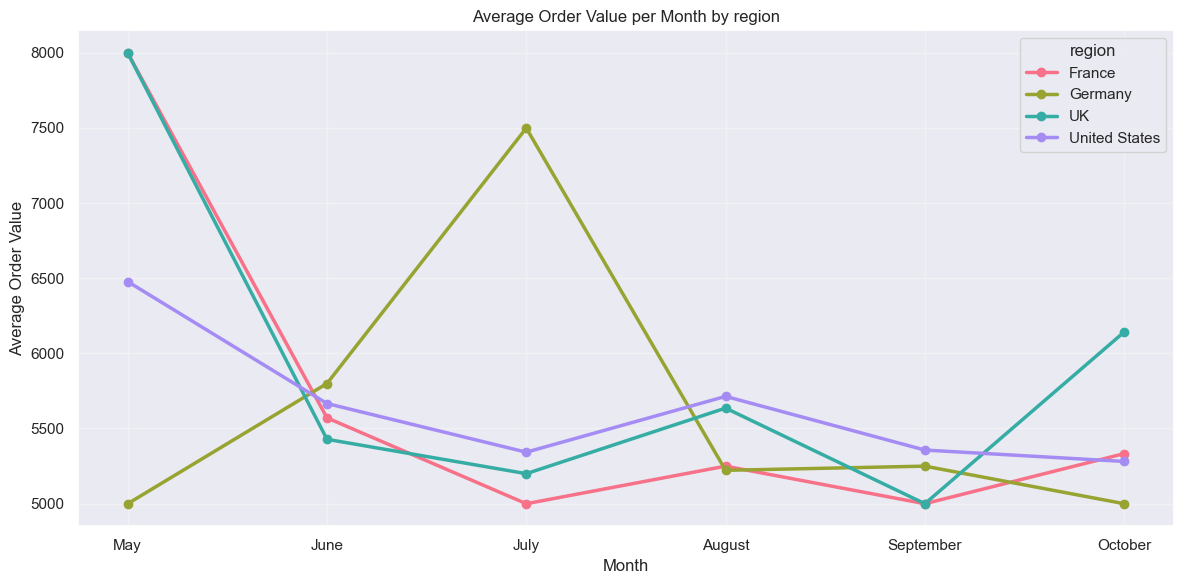

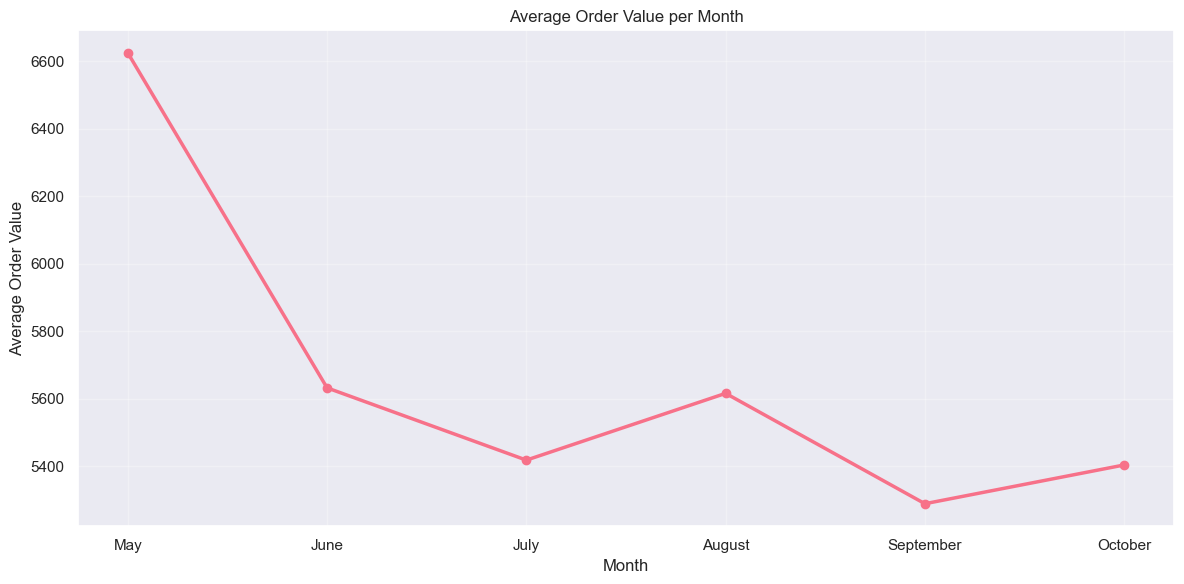

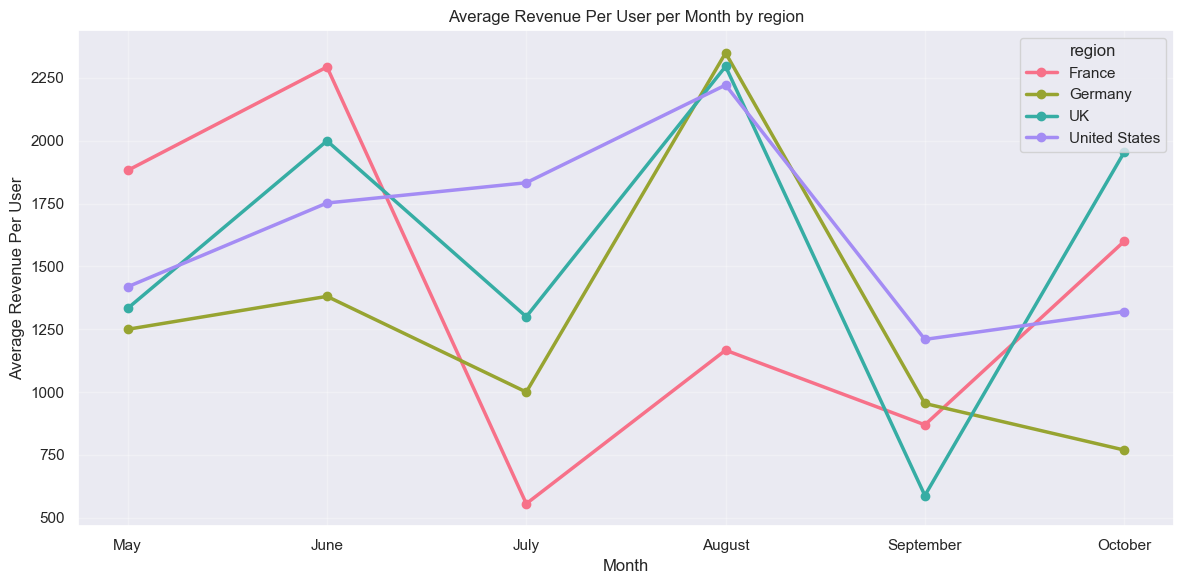

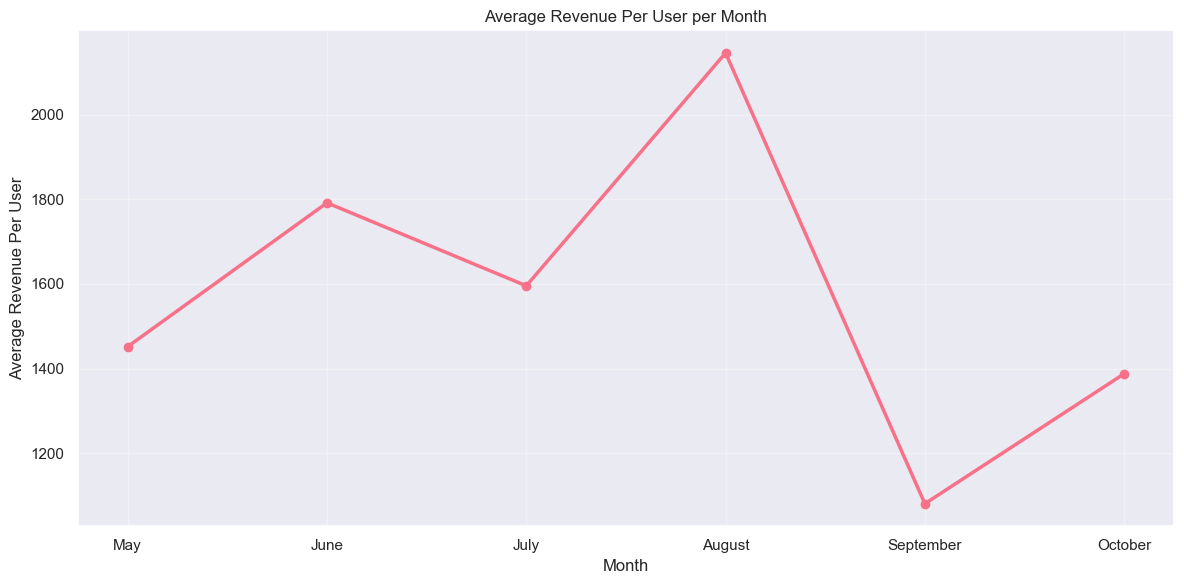

In [13]:
# AOV by region
aov_by_region = calculate_monthly_metric(df, group_col='region', metric_column='revenue', aggregation_method="aov")
plot_monthly_metric(aov_by_region, group_col='region', metric_column='revenue', aggregation_method="aov")

# Average Order Value (AOV) by region
aov = calculate_monthly_metric(df, metric_column='revenue', aggregation_method="aov")
plot_monthly_metric(aov, metric_column='revenue', aggregation_method="aov")

# ARPU by region
arpu_by_region = calculate_monthly_metric(df, group_col='region', metric_column='revenue', aggregation_method="arpu")
plot_monthly_metric(arpu_by_region, group_col='region', metric_column='revenue', aggregation_method="arpu")

# Average Revenue Per User (ARPU) overall
arpu = calculate_monthly_metric(df, metric_column='revenue', aggregation_method="arpu")
plot_monthly_metric(arpu, metric_column='revenue', aggregation_method="arpu")

# 7. How do different payment methods contribute to sales?

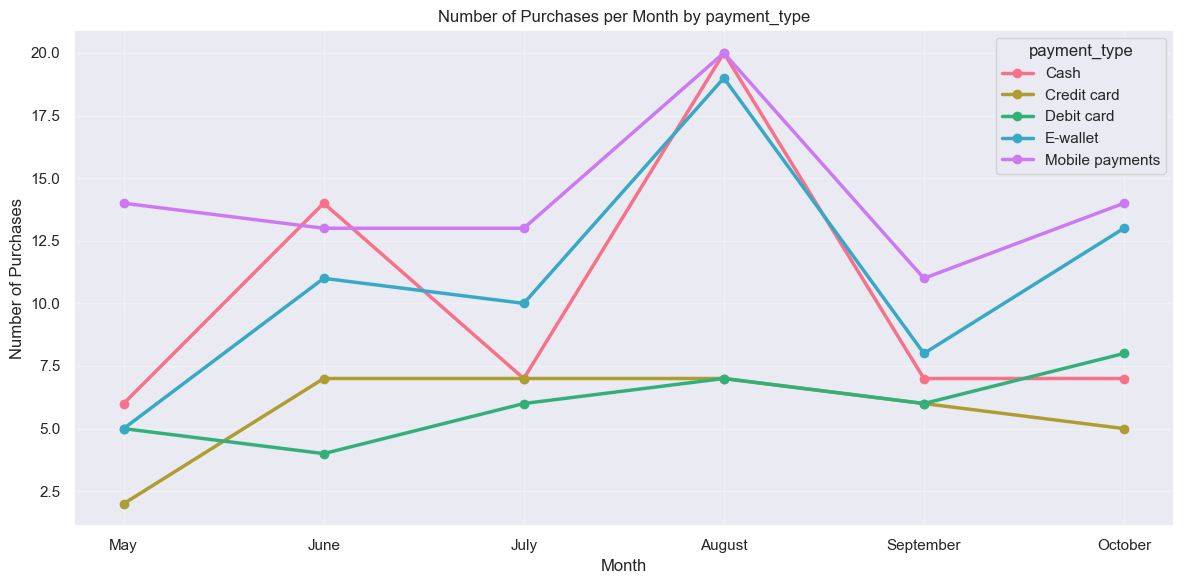

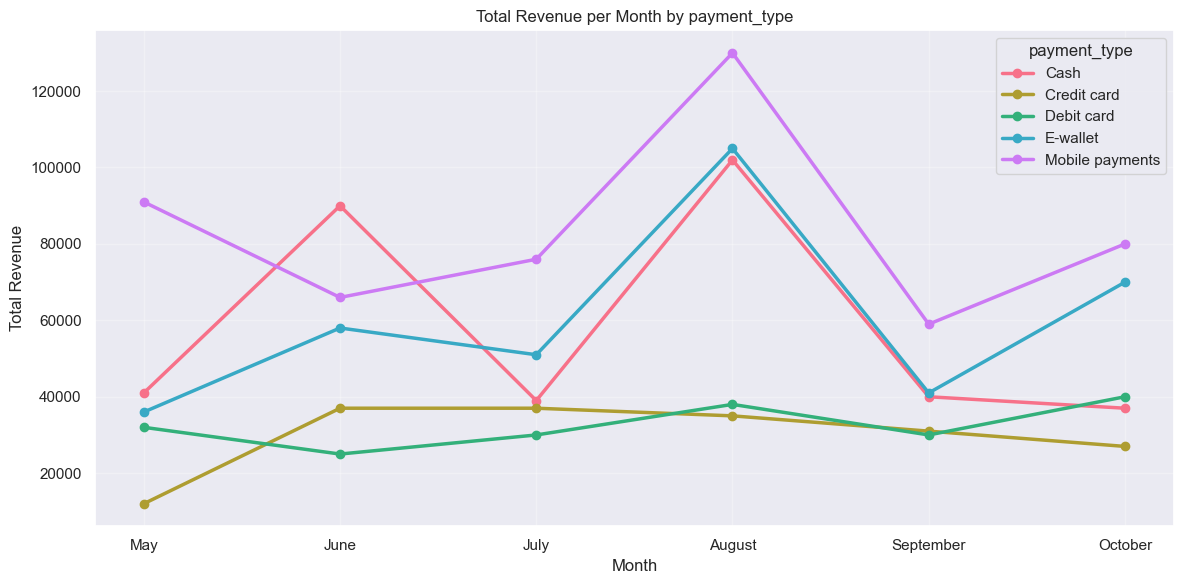

In [14]:
# Purchases by payment type
purchases_by_payment = calculate_monthly_metric(df, group_col='payment_type', aggregation_method="sum")
plot_monthly_metric(purchases_by_payment, group_col='payment_type', aggregation_method="sum")

# Revenue by payment type
revenue_by_payment = calculate_monthly_metric(df, group_col='payment_type', metric_column='revenue', aggregation_method="sum")
plot_monthly_metric(revenue_by_payment, group_col='payment_type', metric_column='revenue', aggregation_method="sum")

# 8. Are there specific times of day when we see more purchases?

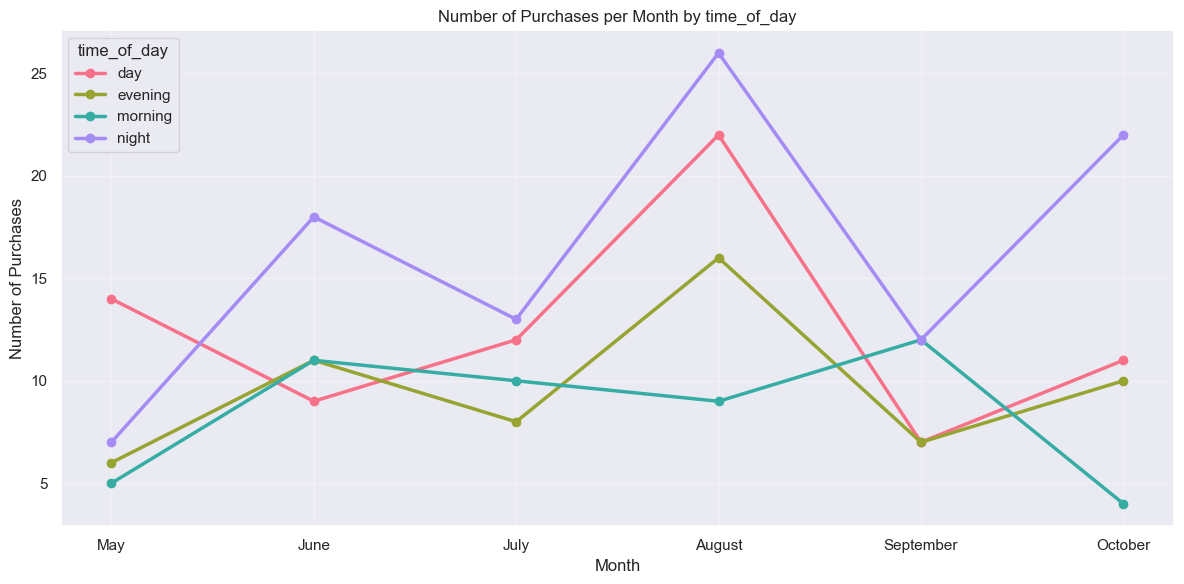

In [15]:
# Purchases by time of day
purchases_by_time = calculate_monthly_metric(df, group_col='time_of_day', aggregation_method="sum")
plot_monthly_metric(purchases_by_time, group_col='time_of_day', aggregation_method="sum")

# 9. Do promo codes drive more sales or higher-value orders?

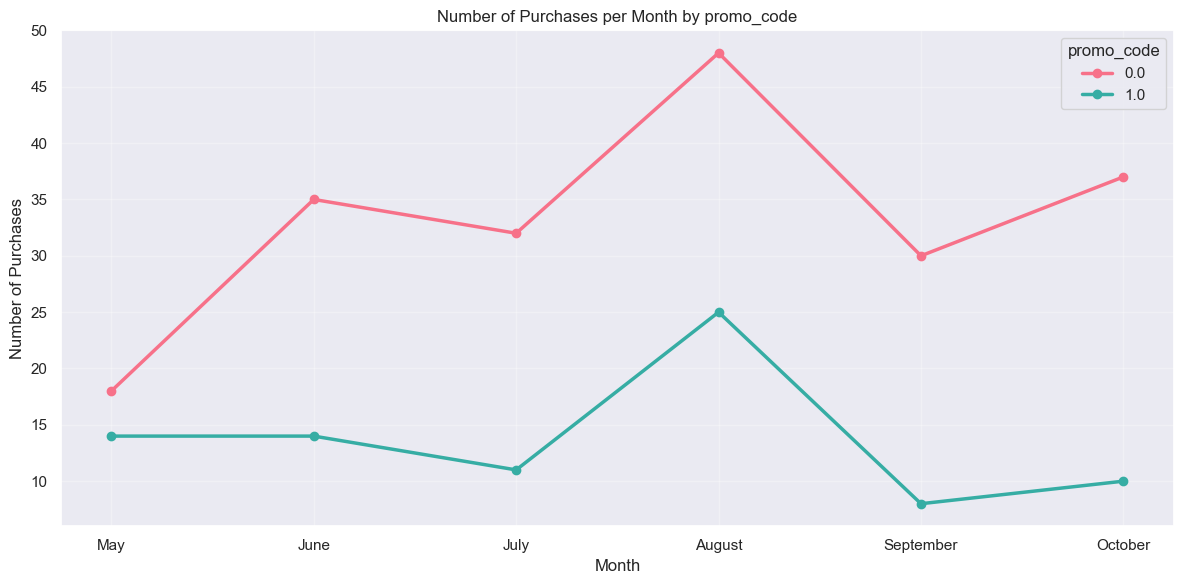

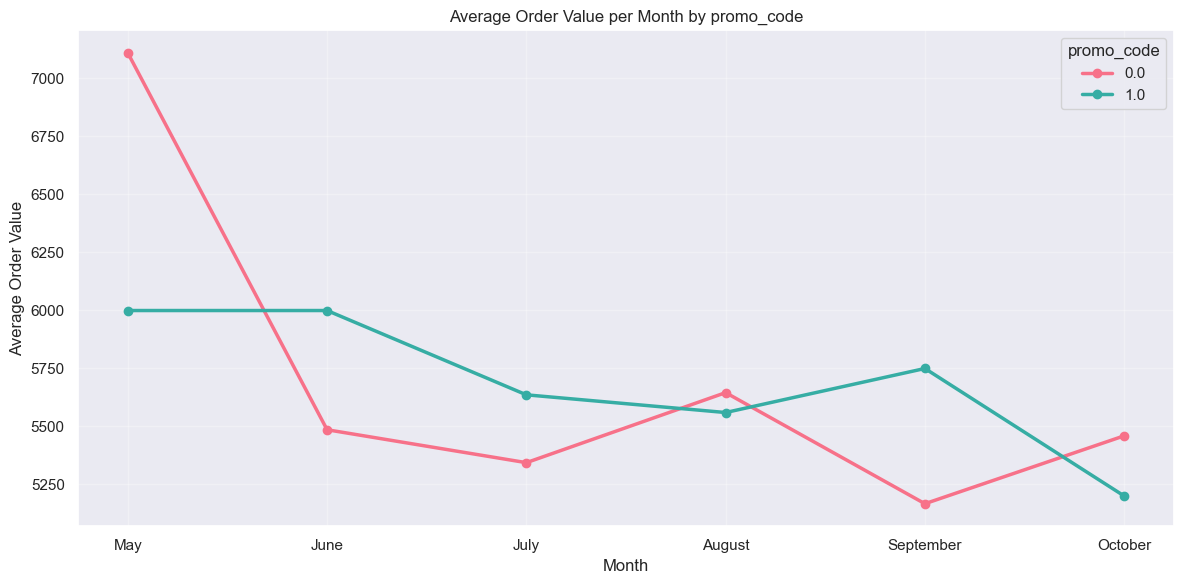

In [16]:
# Purchases with promo codes
purchases_by_promo = calculate_monthly_metric(df, group_col='promo_code', aggregation_method="sum")
plot_monthly_metric(purchases_by_promo, group_col='promo_code', aggregation_method="sum")

# AOV with promo codes
aov_by_promo = calculate_monthly_metric(df, group_col='promo_code', metric_column='revenue', aggregation_method="aov")
plot_monthly_metric(aov_by_promo, group_col='promo_code', metric_column='revenue', aggregation_method="aov")

# Custom Functions 2

In [22]:
def calculate_categorical_metric(
    data, 
    category_col, 
    metric_column='sold', 
    aggregation_method="sum",
    custom_order=None,
    day_mapping=None
):
    """
    Calculate metrics for categorical columns with custom ordering and day number handling.
    
    Args:
        df (pd.DataFrame): Input dataframe
        category_col (str): Column to analyze (e.g., 'day', 'time_of_day')
        metric_column (str): 'sold' or 'revenue'
        aggregation_method (str): 'sum', 'count', 'aov', or 'arpu'
        custom_order (list, optional): Custom order for categories
        day_mapping (dict, optional): Mapping for day numbers to day names
    
    Returns:
        pd.DataFrame: Aggregated metrics with custom ordering
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = data.copy()
    
    # Default day mapping if not provided
    if category_col == 'day' and day_mapping is None:
        day_mapping = {
            1: 'Monday', 
            2: 'Tuesday', 
            3: 'Wednesday', 
            4: 'Thursday', 
            5: 'Friday', 
            6: 'Saturday', 
            7: 'Sunday'
        }
    
    # Apply day mapping if exists
    if day_mapping:
        df[category_col] = df[category_col].map(day_mapping)
    
    # Rest of the function remains the same as in the previous implementation
    # (Use the previous implementation of calculate_categorical_metric)
    
    # Validate inputs
    valid_metric_columns = ['sold', 'revenue']
    if metric_column not in valid_metric_columns:
        raise ValueError(f"metric_column must be one of {valid_metric_columns}")
    
    # Handle revenue-specific calculations
    if metric_column == 'revenue':
        if aggregation_method == 'sum':
            metric = df.groupby(category_col, observed=False)['revenue'].sum()
        elif aggregation_method == 'aov':
            revenue_sum = df[working_df['sold'] == 1].groupby(category_col, observed=False)['revenue'].sum()
            order_count = df[working_df['sold'] == 1].groupby(category_col, observed=False)['sold'].count()
            metric = revenue_sum / order_count
        elif aggregation_method == 'arpu':
            revenue_sum = df.groupby(category_col, observed=False)['revenue'].sum()
            user_count = df.groupby(category_col, observed=False)['user_id'].nunique()
            metric = revenue_sum / user_count
        else:
            raise ValueError("For revenue, use 'sum', 'aov', or 'arpu'")
    else:
        # Sold column logic
        if aggregation_method == "sum":
            metric = df.groupby(category_col, observed=False)['sold'].sum()
        elif aggregation_method == "count":
            metric = df.groupby(category_col, observed=False).size()
        else:
            raise ValueError("For sold, use 'sum' or 'count'")
    
    # Reset index and prepare for plotting
    metric = metric.reset_index(name='metric')
    
    # Apply custom ordering if provided
    if custom_order:
        # Create a categorical type with custom ordering
        metric[category_col] = pd.Categorical(
            metric[category_col], 
            categories=custom_order, 
            ordered=True
        )
        # Sort the dataframe based on the categorical column
        metric = metric.sort_values(category_col)
    
    return metric

def plot_categorical_metric(
    metric, 
    category_col, 
    use_markers=True, 
    metric_column='sold', 
    aggregation_method="count"
):
    """
    Visualize categorical metrics with flexible plotting options.
    """
    plt.figure(figsize=(12, 6))
    
    # Similar to previous plot_monthly_metric function
    title_mapping = {
        ('sold', 'sum'): "Number of Purchases",
        ('sold', 'count'): "Overall Activity",
        ('revenue', 'sum'): "Total Revenue",
        ('revenue', 'aov'): "Average Order Value",
        ('revenue', 'arpu'): "Average Revenue Per User"
    }
    title_metric = title_mapping.get((metric_column, aggregation_method), "Metric")
    
    plt.bar(
        metric[category_col].astype(str), 
        metric['metric']
    )
    
    plt.title(f"{title_metric} by {category_col}")
    plt.xlabel(category_col)
    plt.ylabel(title_metric)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
time_order = ['night', 'morning', 'day', 'evening']

# 10. Which days of the week are most popular for purchases?

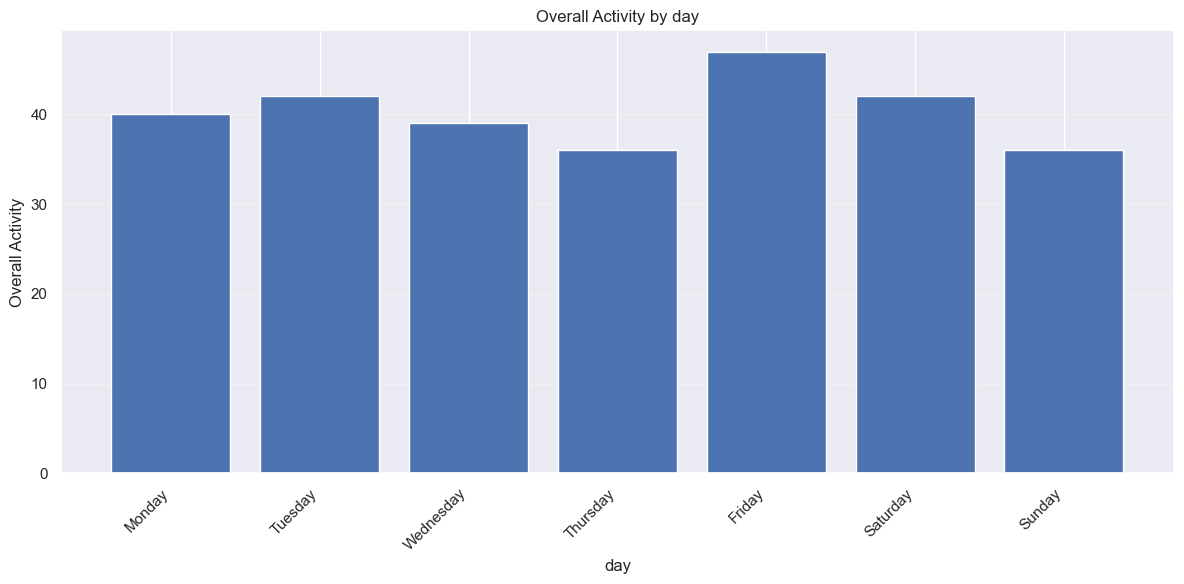

In [23]:
sales_by_day = calculate_categorical_metric(
    df, 
    category_col='day', 
    aggregation_method="sum", 
    custom_order=day_order
)
plot_categorical_metric(sales_by_day, category_col='day')

# 11. What time of day sees the highest sales volume?

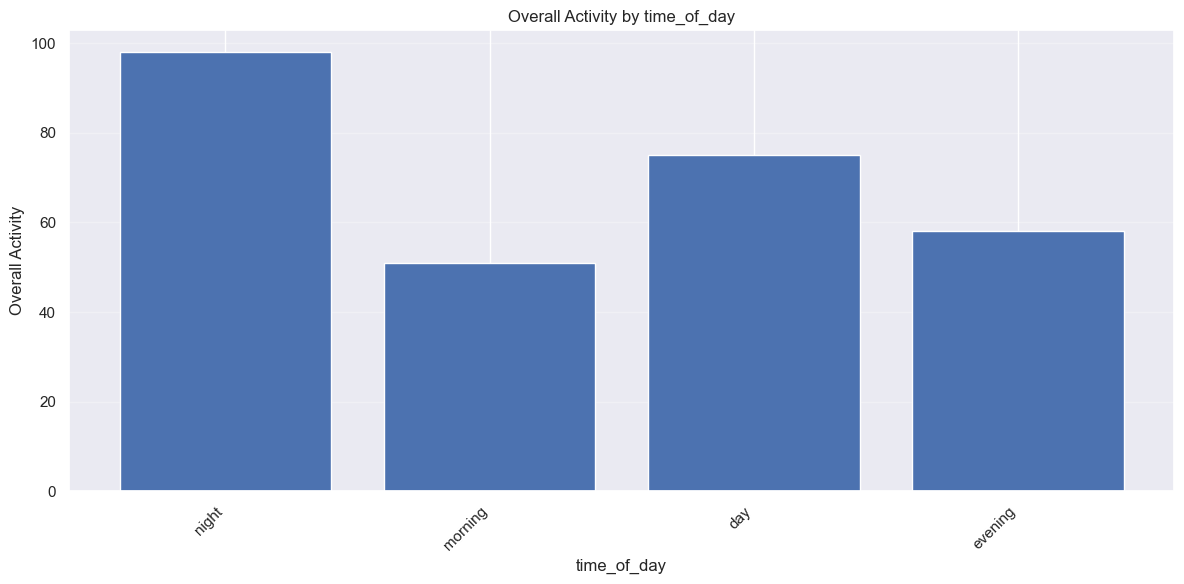

In [25]:
sales_by_time = calculate_categorical_metric(
    df, 
    category_col='time_of_day', 
    aggregation_method="sum", 
    custom_order=time_order
)
plot_categorical_metric(sales_by_time, category_col='time_of_day')